# Homework 2

In this homework, we will once again turn to computational modeling and simulations to better understand the photo-electrical interplay underlying the optogenetic stimulation of neurons. More specifically, you will be tasked to:
- derive the relationship between photo-stimulation parameters and photo-induced current by the Channelrhodopsin-2 (ChR2) excitatory opsin
- evaluate the dependency of neural response metrics on photo-stimulation parameters
- re-evaluate your predictions in light or a more realistic ChR2 current model 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stimulus import CurrentPulseTrain, LightPulseTrain
from model import PyramidalNeuron
from simutils import simulate, detect_spikes
from constants import *

## Provided material

### Global simulation parameters

The parameters governing temporal stimulus application are meant to be kept constant throughout your simulations:

In [2]:
tstart = 20.  # stimulus start time (ms)
tpulse = 200.  # pulse duration (ms)
tstop = 250.  # total simulation time (ms) 

Here's an example stimulus illustrating the temporal pattern of stimulus application:

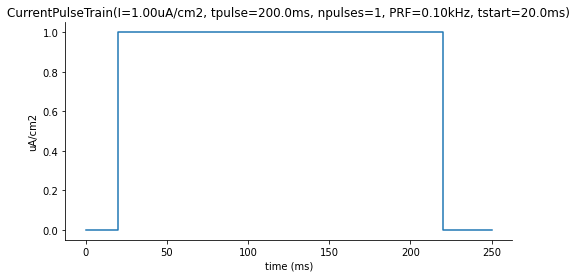

In [3]:
example_stim = CurrentPulseTrain(tpulse=tpulse, tstart=tstart)
fig = example_stim.plot(tstop=tstop)

### Point-neuron model

Our mathematical base to represent neural membrane dynamics is a point-neuron model of a cortical pyramidal neuron composed of various membrane components:
- a membrane capacitance ($C_m = 1\ uF/cm^2$)
- a leakage current $i_{Leak}$ dictating the *resting membrane potential*
- a voltage-gated sodium current $i_{Na}$ (with 3 activation gates *M* and 1 inactivation gate *H*) governing *depolarization*
- a voltage-gated, delayed-rectifier potassium current $i_K$ (with 4 activation gates *N*) governing *repolarization*
- a voltage-gated, slow non-inactivating potassium current $i_M$ (with 1 activation gate *P*) governing *firing rate adaptation* during long spike trains

Its electrical circuit representation is:

![circuit](imgs/circuits-06.png)

And the system's governing equation is:

$$C_m \frac{dV_m}{dt} = i_{stim} - [i_{Leak}(V_m) + i_{Na}(m, V_m) + i_{K}(n, V_m) + i_{M}(p, V_m)]$$

which can be summarized as:

$$C_m \frac{dV_m}{dt} = i_{stim} - i_{membrane}(V_m)$$

where $i_{membrane}(V_m)$ represents the total ionic current flowing through the membrane.

Let's instantiate our neuron model:

In [4]:
model = PyramidalNeuron()
print(model)

PyramidalNeuron(Cm=1.0uF/cm2, currents=[i_Leak, i_Na, i_K, i_M])


As a reminder, here is the response of the neuron model under electrical stimulation:

 15/04/2022 00:10:05: simulating model with CurrentPulseTrain(I=10.00uA/cm2, tpulse=200.0ms, npulses=1, PRF=0.10kHz, tstart=20.0ms) stimulus for 250.0 ms...


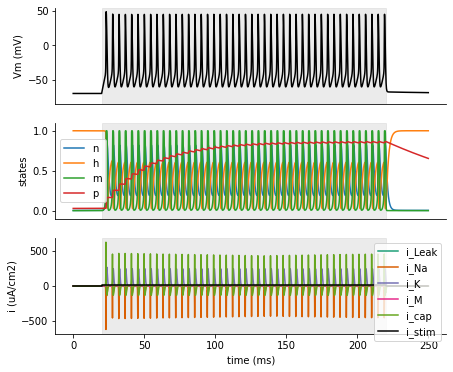

In [5]:
current_stim = CurrentPulseTrain(I=10.0, tpulse=tpulse, tstart=tstart)
data = simulate(model, tstop, stim=current_stim)
fig = data.plot_all(model, stim=current_stim)

### Light pulse train stimulus

You are also provided with a `LightPulseTrain` class representing a light pulse train stimulus. This class can be instantiated with the following parameters:
- `λ`: the optical wavelength (nm)
- `I`: the light intensity (mW/mm2)
- `tpulse`: the pulse duration (ms), given to you above
- `tstart`: the time of the first pulse onset (ms), given to you above

For the sake of this homework, we will only consider the case of 1-photon stimulation and therefore keep the incident light wavelength constant at λ = 480 nm:

In [6]:
λ = 480.  # incident light wavelength (nm)

Here is an example showing you how to instantiate a stimulus with a specific intensity and visualize its time course:

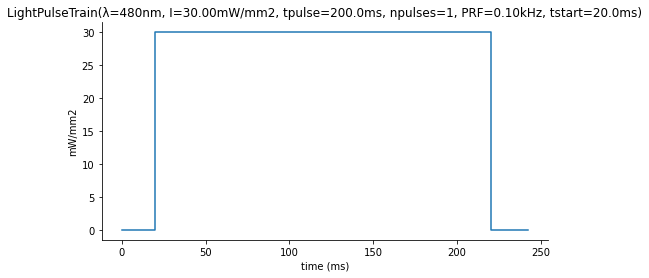

In [7]:
I = 30.  # light intensity (mW/mm2)
light_stim = LightPulseTrain(λ=λ, I=I, tpulse=tpulse, tstart=tstart)
fig = light_stim.plot()

Let's see what happens when we apply this stimulus to our neuron:

 15/04/2022 00:10:07: simulating model with LightPulseTrain(λ=480nm, I=30.00mW/mm2, tpulse=200.0ms, npulses=1, PRF=0.10kHz, tstart=20.0ms) stimulus for 250.0 ms...


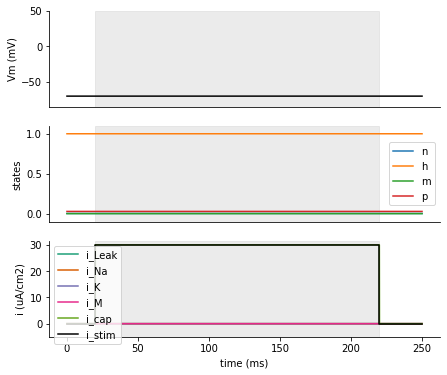

In [8]:
data = simulate(model, tstop, stim=light_stim)
fig = data.plot_all(model, stim=light_stim)

Expectedly, our neuron model comprising only the traditional set of voltage-sensitive ion channels **does not** respond to photo-stimulation.

## Task 1 (7 pts): implement a photostimulus-dependent Channelrhodopsin2 membrane current

In order to simulate photo-induced neural responses, we must add a photo-sensitive Channelrodopsin2 (ChR2) depolarizing current to our model. As a first approximation, we will consider a simplified case and assume that the ChR2 current is a linear function of the photon absorption rate per ChR2 molecule, and thus of the photostimulus properties. 

In order to properly compute this current, we first need to know the rate at which the light stimulus stimulus is absorbed by ChR2 proteins.

Hence, your first task is to **implement 4 transduction functions that handle the progressive conversion of a light stimulus to a photon absorption rate per ChR2 protein**. These functions can be represented in the following transduction chain:

**`(λ, I)`** -> `energy_per_photon` -> `photon_flux_density` -> `incident_photon_rate` -> `photon_absorption_rate` -> `i_Chr`

First, you need to **implement a function computing the energy per photon for a given light wavelength and intensity** (hint: take a look at the recitation slides from the last weeks).

In [27]:
def energy_per_photon(λ):
    ''' 
    Energy per photon.
    
    :param λ: light wavelength (nm)
    :return: energy per photon (J/photon) 
    '''
    ### YOUR CODE GOES HERE

Second, using the previous function, you then need to **implement a function computing the photon flux density (i.e. number of incident photons per unit area and unit time) for a given light wavelength and intensity**:    

In [28]:
def photon_flux_density(λ, I):
    '''
    Photon flux density.
    
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/mm2)
    :return: photon flux per unit area (photons/m2.ms)
    '''
    ### YOUR CODE GOES HERE

Third, using the previous function, you must now **implement a function computing the incident photon rate per ChR2 molecule (i.e. the number of incident photons per ChR2 molecule per unit time) for a given light wavelength and intensity**. To this effect, you are provided with `S_ChR2`, the surface area of the rhodopsin retinal compound where photons are absorbed.

In [29]:
S_ChR2 = 1.2e-20  # cross-section area of rhodopsin retinal compound (m2)

def incident_photon_rate(λ, I):
    '''
    Number of incident photons per ChR2 per unit time.
    
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/mm2)
    :return: incident photons / (ChR2 molecule . ms)
    '''
    ### YOUR CODE GOES HERE

Fourth, using the previous function, you are tasked to **implement a function that computes the photon absorption rate per ChR2 molecule for a given light wavelength and intensity**. To that extent, you are provided with `wloss`, a factor representing the fraction of incidental photons lost due to various factors (intrinsic to the channel, but also due to scattering and absorption phenomena).

In [30]:
wloss = 0.5  # incidental photons loss factor

def photon_absorption_rate(λ, I):
    '''
    Number of photons absorbed per ChR2 per unit time.
    
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/mm2)
    :return: photons absorbed / (ChR2 molecule . ms)
    '''
    ### YOUR CODE GOES HERE

Finally, using the function above, you need to **implement the function `i_Chr` that computes the photo-induced ChR2 current for a given membrane potential `Vm` and specific photo-stimulation parameters (`λ` and `I`)**.

To constrain the problem, you can make the following assumptions:
- Under macrosocopic approximation, the ChR2 membrane conductance $g_{ChR}$ at time $t$ is the product of a maximal conductance $\overline{g_{ChR}}$ (in $S/cm^2$), the ChR2 photon absorption rate at time $t$, and a modulation factor $w$.
- Once open, ChR2 channels induce a non-specific depolarizing current with a specific reversal potential $E_{ChR} = 0 mV$.
- The photon absorption rate si considered to act only as a constant modulation factor (i.e. *unit-less*) in the current computation.

In [37]:
EChR = 0.  # reversal potential (mV)
gChR_bar = .0002  # maximal channel conductance (S/cm2)
w = 10

def i_Chr(Vm, λ, I):
    '''
    Voltage and light-dependent ChR2 current density.

    :param Vm: membrane potential (mV)
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/cm2)
    :return: ChR2 current density (uA/cm2)
    '''
    ### YOUR CODE GOES HERE

Now that you have implemented these functions, **evaluate and visalize the induced ChR2 transmembrane current (in absolute value) for a range of input light intensities** when the neuron's membrane potential is at rest.

*Hint: you can get the neuron's resting membrane potential using the `model.get_Veq` method.* 

In [31]:
intensities = np.logspace(-2, 1.5, 20)  # intensities (mW/mm2)

### YOUR CODE GOES HERE

Let's now add this stimulus-dependent membrane current to our neuron model ...

In [15]:
model.add_stimdep_current(i_Chr)
print(model)

PyramidalNeuron(Cm=1.0uF/cm2, currents=[i_Leak, i_Na, i_K, i_M, i_Chr])


... and re-evaluate its response to a typical light pulse:

 15/04/2022 00:10:08: simulating model with LightPulseTrain(λ=480nm, I=30.00mW/mm2, tpulse=200.0ms, npulses=1, PRF=0.10kHz, tstart=20.0ms) stimulus for 250.0 ms...


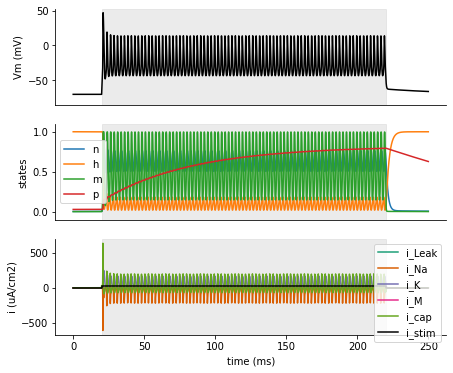

In [16]:
data = simulate(model, tstop, stim=light_stim)
fig = data.plot_all(model, stim=light_stim)

## Task 2 (7 pts): evaluate the dependence of response metrics as a function of stimulus intensity

Now that you have enriched the neuron model with a light-gated Channelrhodopsin current, we can evaluate the influence of photo-stimulation parameters on induced neural responses. In particular, we will focus on 2 particular response metrics:
- the latency of the first induced spike with respect to the stimulus onset
- the number of elicited spikes within the stimulus period (a proxy for the response strength)

In order to properly evaluate these, you must first **implement a `get_latency_and_nspikes` function that will run a simulation with a specific stimulus intensity and extract the response latency and number of spikes from simulation results**:

In [32]:
def get_latency_and_nspikes(model, I):
    '''
    Run simulation with specific light intensity and extract the neuron's
    response latency and number of elicited spikes.
    
    :param model: neuron model object
    :param I: light intensity (mW/cm2)
    :return: (nspikes, latency) tuple where:
        - latency = latency to first spike (in ms) or np.nan (if no spike detected)
        - nspikes = number of detected spikes or np.nan (if no spike detected)
    '''
    ### YOUR CODE GOES HERE

Finally, you can use the implemented `get_latency_and_nspikes` function to **re-evaluate the variations in response latency and response strength (i.e. normalized number of spikes) over a range of stimulus intensities with this new model**. As before, you can **report the results as 2 dependency curves**:

In [33]:
### YOUR CODE GOES HERE

**Discuss how the observed response metrics have changed, and how they relate to the experimental results of [Gefen et al. (2013)](https://doi.org/10.1038/ncomms2500), Figure 3d,e**.

YOUR ANSWER GOES HERE

## Task 3 (3 pts): implement a more realistic Channelrodopsin membrane current

So far, we've considered the simple case of a ChR2 current whose conductance is directly proportional to the ChR2 photon absorption rate. However in reality, the influence of photon absorption on ChR2 conductance is more complex, and can be captured by a multi-state kinetic scheme.

For the purpose of this homework, we will assume that ChR2 can transition between 3 different states (see [Stefanescu 2013](https://doi.org/10.1007/s11538-013-9888-4) paper, section 2.2.1):
- In the absence of optostimulation, ChR2 molecules are assumed to be in state in a closed state *C*.
- Upon illumination, the ChR2 molecules undergo conformational changes and transition to an open state *O*
- ChR2 molecules then spontaneously decays into a closed but desensitized state *D*, in which they are not available to photoswitch on illumination.
- Finally, following a prolonged recovery time period, which is much slower than the time scales involved in the light induced `C -> O` and the spontaneous `O -> D` transitions, the protein returns to the conformation of the closed state *C*.

This 3-states configuration can be captured by the following transition rates kinetic model:

![3-states_model](imgs/3states_model.png)

with, at all times: $C + O + D = 1$.

In this kinetic model, the desensitization rate $G_d$ and the recovery rate $G_r$ are both constants:   

In [19]:
Gd = 1e-2  # rate constant for O -> D transition (ms-1)
Gr = 1e-4  # rate constant for D -> C transition (ms-1)

while the opening rate $P$ depends on the photon absorption rate (and thus on the stimulus characteristic) as well as the quantum yield of photon absorption:

In [20]:
ε = 0.5  # quantum efficiency of photon absorbtion

def P(λ, I):
    ''' 
    Light-dependent excitation rate (for C -> O transition).
    
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/cm2)
    :return: light-dependent excitation rate (ms-1)
    '''
    return ε * photon_absorption_rate(λ, I)  # ms-1

Based on the kinetic model description, **implement 2 functions `do_dt` and `dd_dt`, computing the time-derivatives of the proportion of ChR2 channels in open and desensitized states**, respectively:

In [34]:
def do_dt(o, d, λ, I):
    '''
    Temporal evolution of the proportion of ChR2 channels in open state.

    :param o: proportion of channels in open state
    :param d: proportion of channels in desensitized state
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/cm2)
    :return: time derivative of the proportion of channels in open state (ms-1)
    '''
    ### YOUR CODE GOES HERE
    
def dd_dt(o, d, λ, I):
    '''
    Temporal evolution of the proportion of ChR2 channels in desensitized state.

    :param o: proportion of channels in open state
    :param d: proportion of channels in desensitized state
    :return: time derivative of the proportion of channels in desensitized state (ms-1)
    '''
    ### YOUR CODE GOES HERE

Based on the above implementations, **implement 2 functions `do_dt` and `dd_dt`, computing the steady-state proportions of ChR2 channels in open and desensitized states**, respectively. A few hints:
- Think of what a steady-state means in terms of variation over time
- Use pen and paper to solve the appropriate equations
- Think of a way to handle the special case where $I = 0$
- Look at equivalent implementations in the `tuto_HH.ipynb` notebook for reference.

In [22]:
def o_inf(λ, I):
    '''
    Steady-state proportion of ChR2 channels in open state.
    
    :param λ: light wavelength (nm)
    :param I: light intensity (mW/cm2)
    :return: steady-state proportion
    '''
    ### YOUR CODE GOES HERE

def d_inf(λ, I):
    '''
    Steady-state proportion of ChR2 channels in desensitized state

    :param I: light intensity (mW/cm2)
    :return: steady-state proportion
    '''
    ### YOUR CODE GOES HERE

Now that you have a model of how ChR2 channels will open/close in response to a photo-stimulus, you can **update the formula of the photo-induced transmembrane ionic current `i_Chr`** accordingly.

For this updated configuration, you can assume the following:
- `i_Chr` now behaves as a state-dependent current (as opposed to a stimulus-dependent current), and therefore takes `o`, the proportion of open channels, as an input.
- Under macrosocopic approximation, the ChR2 membrane conductance $g_{ChR}$ at time $t$ is the product of a maximal conductance $\overline{g_{ChR}}$ and the proportion of open ChR2 channels at time $t$, **without a modulation factor**.
- Identically as before, ChR2 channels induce a non-specific depolarizing current with a specific reversal potential $E_{ChR} = 0 mV$.

In [35]:
def i_Chr(o, Vm):
    '''
    Voltage and light-dependent ChR2 current density.

    :param o: proportion of channels in open state
    :param Vm: membrqne potential (mV)
    :return: ChR2 current density (uA/cm2)
    '''
    ### YOUR CODE GOES HERE

Let's now replace the simple ChR2 curent by this more realistic version in our neuron model ...

In [24]:
model.remove_stimdep_current('i_Chr')
model.add_stimdep_state(do_dt, o_inf, ['λ', 'I'])
model.add_stimdep_state(dd_dt, d_inf, ['λ', 'I'])
model.add_current(i_Chr)
print(model)

PyramidalNeuron(Cm=1.0uF/cm2, currents=[i_Leak, i_Na, i_K, i_M, i_Chr])


... and re-evaluate its response to a typical light pulse:

 15/04/2022 00:10:19: simulating model with LightPulseTrain(λ=480nm, I=31.62mW/mm2, tpulse=200.0ms, npulses=1, PRF=0.10kHz, tstart=20.0ms) stimulus for 250.0 ms...


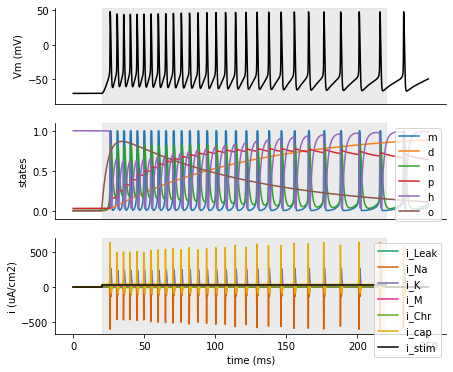

In [25]:
data = simulate(model, tstop, stim=light_stim)
fig = data.plot_all(model, stim=light_stim)

Finally, you can use the implemented `get_latency_and_nspikes` function to **re-evaluate the variations in response latency and response strength (i.e. normalized number of spikes) over a range of stimulus intensities with this new model**. As before, you can **report the results as 2 dependency curves**:

In [36]:
### YOUR CODE GOES HERE

**Discuss how the observed response metrics have changed, and how they relate to the experimental results of [Gefen et al. (2013)](https://doi.org/10.1038/ncomms2500), Figure 3d,e**.

YOUR ANSWER GOES HERE